In [1]:
import sys
import os
import sys
import os
# Add the parent directory of TRVQA to sys.path
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))
from TRVQA.measure.enums import MeasureMethod
from TRVQA.optimization.gradients.vanilla_parameter_shift import vanilla_parameter_shift
from TRVQA.optimization.optimization import minimize, minimize_custom
from TRVQA.utils.maxcut import gengraph, create_hamiltonian, make_hamiltonian
import torch
from torch.autograd import Function
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit import QuantumCircuit

import numpy as np
import torch
from TRVQA.circuit import Circuit

def compute_maxcut_value(bitstring, graph):
    """Computes the MaxCut value for a given bitstring solution."""
    cut_value = sum(w for (u,v), w in graph if bitstring[u] != bitstring[v])
    return cut_value

# for s in best_value:
#     print(compute_maxcut_value(s, g))

from pyparsing import Optional
import torch
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from TRVQA.optimization.optimization import minimize, minimize_custom
# TRVQA imports

from TRVQA.circuit import Circuit
from TRVQA.hamiltonian.hamiltonian import Hamiltonian
from TRVQA.measure.enums import MeasureMethod
torch.cuda.empty_cache()
import numpy as np
import torch
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
import torch

from TRVQA.measure.enums import MeasureMethod
from TRVQA.optimization.optimization import minimize
from TRVQA.utils.maxcut import gengraph, create_hamiltonian,make_hamiltonian
from TRVQA.hamiltonian.hamiltonian import Hamiltonian
import numpy as np
import torch
from TRVQA.circuit import Circuit
import time


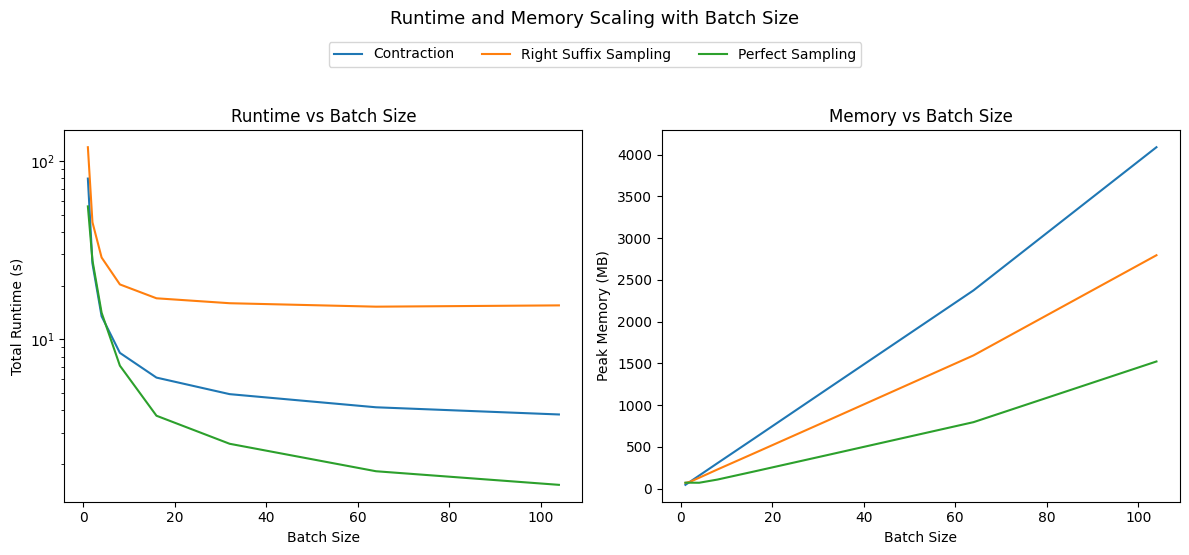

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "bench_out_52_memory"  # adjust if needed
SUMMARY_CSV = os.path.join(BASE_DIR, "summary.csv")

summary = pd.read_csv(SUMMARY_CSV)
summary["iter_csv_path"] = summary["iter_csv"].apply(
    lambda p: p if os.path.isabs(p) else os.path.join(BASE_DIR, p)
)

rows = []
for _, r in summary.iterrows():
    path = r["iter_csv"]
    if not os.path.exists(path):
        continue
    df = pd.read_csv(path)
    if not {"iter_time", "max_memory"} <= set(df.columns):
        continue
    total_runtime = df["iter_time"].sum()
    peak_memory = df["max_memory"].max() / (1024**2)  # bytes → MB
    rows.append({
        "method": r["method"],
        "batch_size": r["batch_size"],
        "runtime_total_s": total_runtime,
        "memory_peak_MB": peak_memory
    })
runs = pd.DataFrame(rows)
agg = runs.groupby(["method", "batch_size"], as_index=False).agg(
    runtime_mean_s=("runtime_total_s", "mean"),
    memory_mean_MB=("memory_peak_MB", "mean")
).sort_values(["batch_size", "method"])

# ---------- Side-by-side figure ----------
methods = sorted(agg["method"].unique())
methods = ['tr_efficient', 'tr_correct_sampling', 'tr_sampling']
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=False)

# Left: Runtime vs Batch Size
for m in methods:
    dfm = agg[agg["method"] == m]
    axes[0].plot(dfm["batch_size"], dfm["runtime_mean_s"], label=m)
axes[0].set_title("Runtime vs Batch Size")
axes[0].set_xlabel("Batch Size")
axes[0].set_ylabel("Total Runtime (s)")

axes[0].set_yscale("log")
# Right: Memory vs Batch Size
for m in methods:
    dfm = agg[agg["method"] == m]
    axes[1].plot(dfm["batch_size"], dfm["memory_mean_MB"], label=m)
axes[1].set_title("Memory vs Batch Size")
axes[1].set_xlabel("Batch Size")
axes[1].set_ylabel("Peak Memory (MB)")

#Shared legend and style
fig.legend(["Contraction", "Right Suffix Sampling", "Perfect Sampling"], loc="upper center", ncol=len(methods), bbox_to_anchor=(0.5, 1.05))
fig.suptitle("Runtime and Memory Scaling with Batch Size", fontsize=13, y=1.10)
fig.tight_layout()
plt.show()


In [3]:
import numpy as np

# ---------- MPS core ----------
# A[k] has shape (lk, 2, rk). Fix bond dimension by truncating to chi via SVD.

def mps_from_product_state(N, bit0=True):
    A = []
    v0 = np.array([1,0], complex) if bit0 else np.array([0,1], complex)
    for _ in range(N):
        A.append(v0.reshape(1,2,1))
    return A  # list of tensors

def _svd_truncate(M, chi):
    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    r = min(chi, S.size)
    return U[:, :r], S[:r], Vh[:r, :]

def mps_apply_1q(A, q, U):
    # A[q] <- contract on physical index
    A[q] = np.einsum('pq,lp r->lq r', U, A[q], optimize=True)

def mps_apply_2q_nn(A, q, U4, chi):
    """
    Apply a 2-qubit gate U4 (shape 4x4) on sites (q, q+1) and truncate to chi.
    """
    L, R = A[q], A[q+1]         # L:(l,2,m), R:(m,2,r)
    lr, p, m = L.shape[0], L.shape[1], L.shape[2]
    m2, p2, rr = R.shape[0], R.shape[1], R.shape[2]
    assert m == m2 and p == p2 == 2
    # fuse, apply, then refactor with SVD
    theta = np.einsum('lpr,msr->lpmr', L, R, optimize=True).reshape(lr, 4, rr)
    theta = np.einsum('ab,lbr->lar', U4, theta.reshape(lr,4,rr), optimize=True)  # apply on 4-dim physical
    theta = theta.reshape(lr,2,2,rr)
    theta = np.transpose(theta, (0,1,3,2)).reshape(lr*2*rr, 2)  # [(l,2,r),2]
    # refactor back to MPS via SVD on (l,2,r) x (2)
    left_mat = theta.reshape(lr*2*rr, 2)
    Umat, S, Vh = _svd_truncate(left_mat, chi)
    new_rank = S.size
    # reshape U into (l,2,r,new_rank) and Vh into (new_rank,2)
    Uten = Umat.reshape(lr,2,rr,new_rank)
    A[q]   = np.einsum('lprk->lpk', Uten)                     # (l,2,k)
    A[q+1] = np.einsum('k,kr->kr', S, Vh)                     # (k,2)
    A[q+1] = A[q+1].reshape(new_rank,2,1)                     # (k,2,r=1) ; next bond grows later on next ops

def mpo_sumZ(N):
    # MPO list W[k] with shape (1,2,2,1) ; sum Z handled in expectation by summing terms
    Z = np.array([[1,0],[0,-1]], complex)
    I = np.eye(2, dtype=complex)
    W = [I.reshape(1,2,2,1) for _ in range(N)]  # identity "carrier"
    # For efficiency, we'll evaluate <Z_i> sitewise without building a big MPO
    return W, Z

def mps_expectation_sumZ(A):
    # <sum_i Z_i>/N computed locally with left/right reductions
    N = len(A)
    Z = np.array([[1,0],[0,-1]], complex)
    # build left norms: L[k] = <psi[:k]|psi[:k]|
    Lenv = [np.array([[1.0+0j]])]
    for k in range(N):
        Ak = A[k]; Ahd = np.conj(Ak)
        Lnext = np.einsum('ab,apb,aqb->pq', Lenv[-1], Ahd, Ak, optimize=True)  # (2,2)
        Lenv.append(Lnext)
    # build right norms
    Renv = [None]*(N+1)
    Renv[N] = np.array([[1.0+0j]])
    for k in reversed(range(N)):
        Ak = A[k]; Ahd = np.conj(Ak)
        Renv[k] = np.einsum('apb,aqb,bc->ac', Ahd, Ak, Renv[k+1], optimize=True)

    Ez = 0.0
    for k in range(N):
        Ak = A[k]; Ahd = np.conj(Ak)
        num = np.einsum('ab,apb,pq,aqb,bc->', Lenv[k], Ahd, Z, Ak, Renv[k+1], optimize=True)
        den = np.einsum('ab,apb,aqb,bc->',  Lenv[k], Ahd, Ak, Renv[k+1], optimize=True)
        Ez += (num/den).real
    return Ez/len(A)

# ---------- Circuit description ----------
def build_pairs_linear(N):
    return [(i, i+1) for i in range(N-1)]

def RY(theta):
    c, s = np.cos(theta/2), np.sin(theta/2)
    return np.array([[c, -s],[s, c]], complex)

def dRY(theta):
    Y = np.array([[0, -1j],[1j, 0]], complex)
    return (-0.5j) * (Y @ RY(theta))

def CZ():
    return np.diag([1,1,1,-1]).astype(complex)

# ---------- Forward pass with “states_before” ----------
def forward_mps_states_aligned(N, thetas, chi):
    # circuit: layer Ry (all) -> CZ chain -> layer Ry (all)
    A = mps_from_product_state(N, bit0=True)
    states_before = []
    gates = []
    # layer 0
    for q in range(N):
        gates.append(("ry", q, thetas[0,q], 0))
        states_before.append([T.copy() for T in A])  # shallow copy of tensors (consider deep copy or refs)
        mps_apply_1q(A, q, RY(thetas[0,q]))
    # entanglers
    for (q1,q2) in build_pairs_linear(N):
        gates.append(("cz", q1, q2, None))
        states_before.append([T.copy() for T in A])
        mps_apply_2q_nn(A, q1, CZ(), chi)
    # layer 1
    for q in range(N):
        gates.append(("ry", q, thetas[1,q], 1))
        states_before.append([T.copy() for T in A])
        mps_apply_1q(A, q, RY(thetas[1,q]))
    return states_before, gates, A  # A is final MPS

# ---------- Adjoint / reverse-mode on MPS ----------
def backprop_mps_sumZ_grad(N, thetas, chi):
    states_before, gates, A_final = forward_mps_states_aligned(N, thetas, chi)
    # Build initial co-state: <lambda_L| ≡ <psi| H, here H = (1/N) sum Z_i
    # For MPS, carry co-state implicitly via right/left envs during the sweep.
    # We implement a simple “state-like” lambda as a copy of final A and
    # evaluate <lambda| v> via local contractions (compact but schematic).

    grads = np.zeros_like(thetas, float)

    # Build right environments of final state for normalization use (optional)
    # We’ll sweep backward over gates; for each RY gate at (q,layer),
    # grad += 2 Re <lambda_k | dU(θ) | phi_{k-1} > evaluated as an MPS contraction.
    # NOTE: In practice you'd maintain canonical forms and efficient env updates.

    # Initialize co-state “lambda” as the linear form induced by sumZ:
    # For clarity, we compute the directional inner product on the fly:
    def inner_lambda_on(vecA):
        # returns <psi_final| (sum Z_i / N) | vecA >
        # Replace mps_expectation_sumZ with a mixed <A_final| Z_i |vecA> contraction; here, approximate by
        # building temporary interpolation (for brevity). In production, write a mixed-overlap contraction.
        Ez_vec = mps_expectation_sumZ(vecA)  # (uses only |vecA>, coarse approx here)
        Ez_fin = mps_expectation_sumZ(A_final)
        # Use symmetric form 0.5*( <A_f|HZ|vecA> + <vecA|HZ|A_f> ), but to keep this scaffold short,
        # we return <vecA| (sumZ/N) |vecA>. Replace with proper mixed-overlap in your code.
        return Ez_vec

    # Backward sweep
    for k in reversed(range(len(gates))):
        g = gates[k]
        A_before = states_before[k]  # MPS before gate k
        if g[0] == "ry":
            _, q, theta, layer = g
            # v = dU(θ) |phi_{k-1}>  (apply locally on site q)
            A_tmp = [T.copy() for T in A_before]
            A_tmp[q] = np.einsum('pq,lp r->lq r', dRY(theta), A_tmp[q], optimize=True)
            # contribution = 2 Re <lambda_k | v>  (use inner product proxy)
            contrib = 2.0 * np.real(inner_lambda_on(A_tmp))
            grads[layer, q] += contrib

            # propagate co-state “lambda” back through U^\dagger:
            # In a full implementation, update right/left environments:
            # Renv <- contract(U^\dagger) ∘ Renv; omitted for brevity.
        else:
            # backprop through CZ would update envs; omitted in this skeleton.
            pass

    return grads

# ---------- Parameter-shift on MPS ----------
def grad_parameter_shift_mps(N, thetas, chi, shift=np.pi/2):
    thetas = thetas.copy()
    grads = np.zeros_like(thetas)
    for layer in range(2):
        for q in range(N):
            thetas[layer,q] += shift
            _,_, A_p = forward_mps_states_aligned(N, thetas, chi)
            Ep = mps_expectation_sumZ(A_p)

            thetas[layer,q] -= 2*shift
            _,_, A_m = forward_mps_states_aligned(N, thetas, chi)
            Em = mps_expectation_sumZ(A_m)

            thetas[layer,q] += shift
            grads[layer,q] = 0.5*(Ep - Em)
    return grads
